## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from sklearn.model_selection import train_test_split
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


### Step 1. Define Model Input

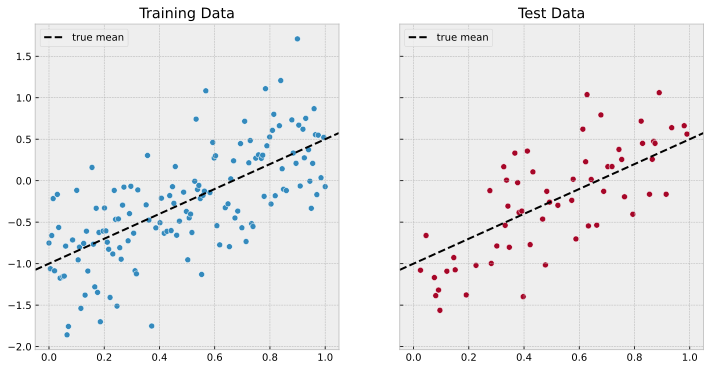

In [2]:
np.random.seed(seed=42)

a_true = -1.0
b_true = 1.5
sigma_true = 0.5
n = 200


def generate_sample_data(a, b, sigma, n):
    x = np.linspace(start=0.0, stop=1, num=n).reshape(n, 1)
    mu_true = a + b * x
    y = np.random.normal(loc=mu_true, scale=sigma, size=(n, 1))
    x_train, x_test, y_train, y_test = [
        x.flatten() for x in train_test_split(x, y, test_size=0.3, random_state=42)
    ]
    y_train = y_train[np.argsort(x_train)]
    x_train = x_train[np.argsort(x_train)]
    y_test = y_test[np.argsort(x_test)]
    x_test = x_test[np.argsort(x_test)]

    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = generate_sample_data(
    a=a_true, b=b_true, sigma=sigma_true, n=n
)

n_train = x_train.shape[0]
n_test = x_test.shape[0]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)
sns.scatterplot(x=x_train, y=y_train, color="C0", ax=ax[0])
sns.scatterplot(x=x_test.squeeze(), y=y_test, color="C1", ax=ax[1])
ax[0].axline(
    xy1=(0, a_true), slope=b_true, color="black", linestyle="--", label="true mean"
)
ax[1].axline(
    xy1=(0, a_true), slope=b_true, color="black", linestyle="--", label="true mean"
)
ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left")
ax[0].set(title="Training Data")
ax[1].set(title="Test Data");


### Step 2. Model Specification

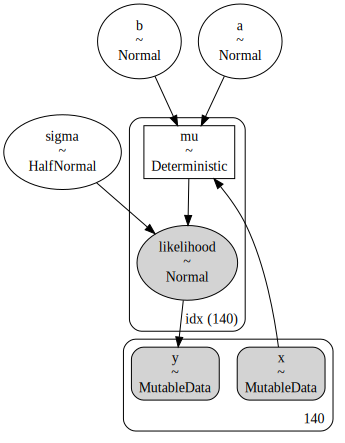

In [3]:
with pm.Model(coords={"idx": range(n_train)}) as model:
    # --- Data Containers ---
    x = pm.MutableData(name="x", value=x_train)
    y = pm.MutableData(name="y", value=y_train)
    # --- Priors ---
    a = pm.Normal(name="a", mu=0, sigma=2)
    b = pm.Normal(name="b", mu=0, sigma=2)
    sigma = pm.HalfNormal(name="sigma", sigma=2)
    # --- Model Parametrization ---
    mu = pm.Deterministic(name="mu", var=a + b * x, dims="idx")
    # --- Likelihood ---
    likelihood = pm.Normal(
        name="likelihood", mu=mu, sigma=sigma, observed=y, dims="idx"
    )

pm.model_to_graphviz(model=model)


### 3. Prior Predictive Checks

In [4]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=100)

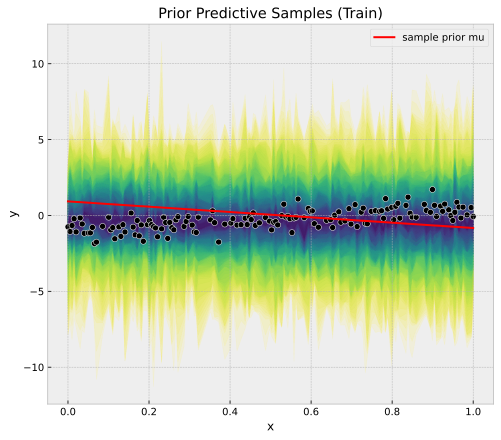

In [5]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(8, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=x_train,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )
sns.lineplot(
    x=x_train,
    y=prior_predictive.prior["mu"][0, 0, :],
    color="red",
    label="sample prior mu",
    ax=ax,
)
sns.scatterplot(
    x=x_train,
    y=y_train,
    color="black",
    ax=ax,
)
ax.set(title="Prior Predictive Samples (Train)", xlabel="x", ylabel="y");


### 4. Fit Model

In [6]:
with model:
    idata = pm.sample(
        target_accept=0.8, draws=1_000, chains=4
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8889, but should be close to 0.8. Try to increase the number of tuning steps.


###  5. Model Diagnostics

In [7]:
var_names = ["a", "b", "sigma"]

In [8]:
az.summary(data=idata, var_names=var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a     -1.036  0.079  -1.179   -0.883      0.002    0.001    1955.0    2137.0   
b      1.522  0.137   1.255    1.767      0.003    0.002    1890.0    1902.0   
sigma  0.482  0.030   0.428    0.538      0.001    0.000    2491.0    2155.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0

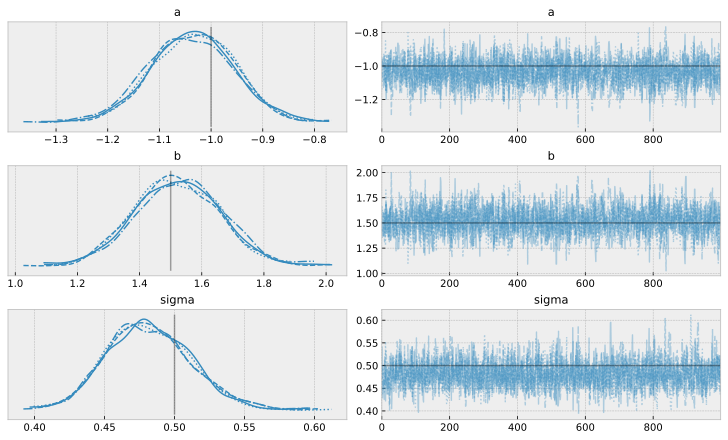

In [9]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    lines=[("a", {}, [a_true]),("b", {}, [b_true]), ("sigma", {}, [sigma_true])],
    compact=True,
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},
)

### 6. Posterior Predictive (Train)

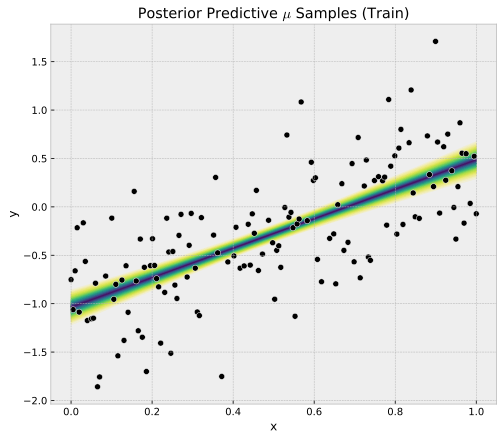

In [10]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_mu_train = idata.posterior["mu"].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(figsize=(8, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_mu_train, p, axis=1)
    lower = np.percentile(posterior_predictive_mu_train, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=x_train,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.scatterplot(x=x_train,y=y_train,color="black",ax=ax,)
ax.set(title="Posterior Predictive $\mu$ Samples (Train)", xlabel="x", ylabel="y");


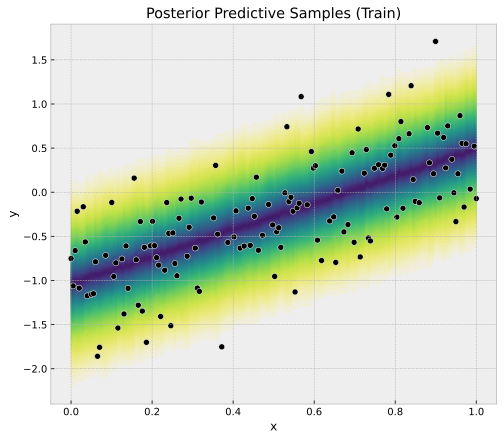

In [11]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_likelihood_train = posterior_predictive.posterior_predictive[
    "likelihood"
].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(figsize=(8, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_train, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_train, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=x_train,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.scatterplot(x=x_train,y=y_train,color="black",ax=ax,)
ax.set(title="Posterior Predictive Samples (Train)", xlabel="x", ylabel="y");


### 7. Posterior Predictive (Test)

In [67]:
np.linspace(-10, 10).shape

(50,)

In [72]:
with model:
    pm.set_data({"x": x_test, "y": y_test})
    idata.extend(
        other=pm.sample_posterior_predictive(
            trace=idata,
            var_names=["likelihood", "mu"],
            idata_kwargs={"coords": {"idx": range(n_test)}},
        ),
        join="right",
    )


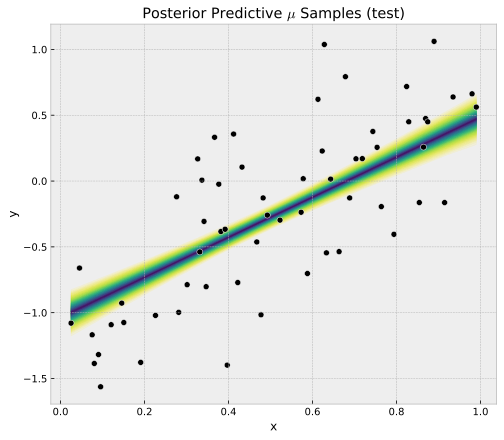

In [73]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_mu_test = idata.posterior_predictive["mu"].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(figsize=(8, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_mu_test, p, axis=1)
    lower = np.percentile(posterior_predictive_mu_test, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=x_test,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.scatterplot(x=x_test,y=y_test,color="black",ax=ax,)
ax.set(title="Posterior Predictive $\mu$ Samples (test)", xlabel="x", ylabel="y");

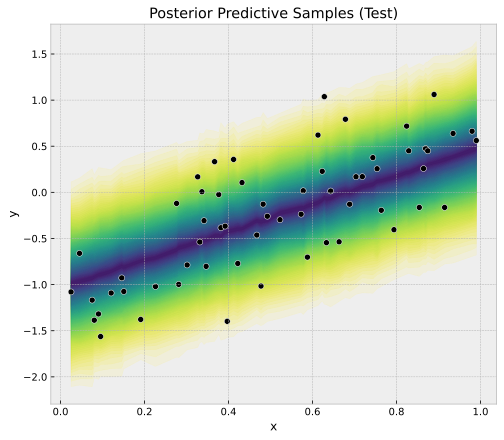

In [74]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_likelihood_test = idata.posterior_predictive["likelihood"].stack(
    sample=("chain", "draw")
)

fig, ax = plt.subplots(figsize=(8, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_test, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_test, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=x_test,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.scatterplot(x=x_test,y=y_test,color="black",ax=ax,)
ax.set(title="Posterior Predictive Samples (Test)", xlabel="x", ylabel="y");

---

<AxesSubplot:ylabel='Count'>

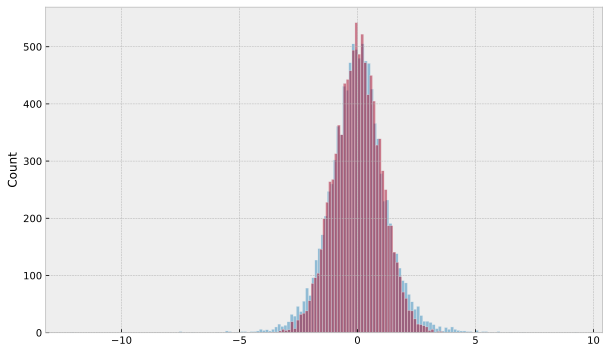

In [115]:
#sns.histplot(x=np.random.laplace(loc=0.0, scale=1, size=10_000))
fig, ax = plt.subplots()
sns.histplot(x=np.random.standard_t(df=6, size=10_000), color="C0", alpha=0.5, ax=ax)
sns.histplot(x=np.random.normal(size=10_000), color="C1", alpha=0.5, ax=ax)